In [1]:
import mido
from mido import Message, MidiFile, MidiTrack,MetaMessage
import string
import numpy as np
import pandas as pd
from midi_arr import *
from demo.midi_array import *
import os
import csv
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Load data

In [3]:
# # label path     
# label_path = r'D:\BrownUniversity\CS2470\final_proj\CS2470_final\data\label.csv'
# # Define the folder path
# folder_path = r'D:\BrownUniversity\CS2470\final_proj\CS2470_final\data\test'
# # load data
# music,label, align_length = get_music_data(folder_path, label_path)

In [4]:
music = load_music()
label = load_label()

In [5]:
print(len(music))
print(music[0].shape)


1078
(500, 3)


In [6]:
# help function
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot_labels[i, label - 1] = 1
    return one_hot_labels

# onehot_encode
labels = one_hot_encode(label,4)

In [13]:
def convert_music(reconstruction):
    # Split the tensor into the main part and the last 4 elements
    main_part = reconstruction[..., :-4]
    last_4_elements = reconstruction[..., -4:]

    predicted_notes, predicted_velocities, predicted_times = torch.chunk(main_part, chunks=3, dim=-1)
    # notes
    predicted_notes = torch.sigmoid(predicted_notes)
    predicted_notes = (predicted_notes * (90 - 30)) + 30
    # velocities
    predicted_velocities = torch.sigmoid(predicted_velocities)
    predicted_velocities = (predicted_velocities * 127) + 0
    # time
    predicted_times = torch.sigmoid(predicted_times)
    predicted_times = (predicted_times * 110) + 0
    
    # Concatenate the processed main part with the last 4 elements
    reconstructed_music = torch.cat((predicted_notes, predicted_velocities, predicted_times, last_4_elements), dim=-1)
    
    return reconstructed_music


In [130]:
def min_max_normalize(tensor, min_value, max_value):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = min_value + (tensor - min_val) * (max_value - min_value) / (max_val - min_val)
    return normalized_tensor

def convert_reco(reconstruction):
    # notes
    notes = reconstruction[:,::3] 
    notes = min_max_normalize(notes,21,108)
    # velocity 
    velocity = reconstruction[:, 1::3]  
    velocity = min_max_normalize(notes,0,127)
    # time
    time = reconstruction[:, 2::3] 
    time = min_max_normalize(notes,0,300)

    return notes,velocity,time

def comb_reco(notes,velocity,time):
    stacked_tensor = torch.stack((notes, velocity, time), dim=1)
    stacked_tensor = stacked_tensor.squeeze()
    reconstruction = stacked_tensor.t().flatten()
    return reconstruction

In [131]:
def convert_loss(reconstruction):
    # note
    notes = reconstruction[::3] 
    notes = min_max_normalize(notes,21,108)
    # velocity 
    velocity = reconstruction[1::3]  
    velocity = min_max_normalize(notes,0,127)
    # time
    time = reconstruction[2::3] 
    time = min_max_normalize(notes,0,300)

    return notes,velocity,time

## CVAE

In [132]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_classes, dropout_prob=0.5):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size + num_classes, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3_mean = nn.Linear(hidden_size, latent_size)
        self.fc3_logvar = nn.Linear(hidden_size, latent_size)
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x, y):
        # Concatenate input with class information
        # y = y.view(-1, 1)
        x = torch.cat((x, y), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        mean = self.fc3_mean(x)
        # Convert mean to one-hot encoded format
        _, max_indices = mean.max(dim=1)
        mean_one_hot = torch.zeros(mean.size(), dtype=torch.float32)
        mean_one_hot.scatter_(1, max_indices.view(-1, 1), 1)

        logvar = self.fc3_logvar(x)
        _, logvar_indice = logvar.max(dim=1)
        logvar_one_hot = torch.zeros(logvar.size(), dtype=torch.float32)
        logvar_one_hot.scatter_(1, logvar_indice.view(-1, 1), 1)

        return mean_one_hot, logvar_one_hot

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_classes):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size + num_classes, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(84, 500)
        
    def forward(self, z, y):
        # Concatenate latent variable with class information
        z = torch.cat((z, y), dim=1)
        z = F.relu(self.fc1(z))
        reconstruction = self.fc2(z)  
        # Convert reconstruction 
        notes,velocity,time = convert_reco(reconstruction)
        notes = self.fc3(notes)
        velocity = self.fc3(velocity)
        time = self.fc3(time)
        reconstruction = comb_reco(notes,velocity,time)

        return reconstruction

class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size, num_classes):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size, num_classes)
        self.decoder = Decoder(latent_size, hidden_size, output_size, num_classes)
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, y):
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        mean, logvar = self.encoder(x, y)
        # print(f"mean:{mean}")
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z, y)
        # print(f"reconstruction:{reconstruction}")
        return reconstruction, mean, logvar



In [133]:
# # TODO change shape
input_size = 500 * 3
hidden_size = 252
latent_size = 4
num_classes = 4
output_size = 250 * 3
cvae_model = CVAE(input_size, hidden_size, latent_size, output_size, num_classes)

In [134]:
# Define optimizer
learning_rate = 0.05
optimizer = optim.Adam(cvae_model.parameters(), lr=learning_rate)
# Define loss function
def melody_loss(predicted_notes, target_notes):
    return nn.CrossEntropyLoss()(predicted_notes, target_notes)

def harmony_loss(predicted_chords, target_chords):
    return nn.CrossEntropyLoss()(predicted_chords, target_chords)

def rhythm_loss(predicted_times, target_times):
    return nn.MSELoss()(predicted_times, target_times)

def hierarchical_music_loss(predicted_music, target_music):
    # Extract different components of the music (e.g., notes, velocities, times)
    predicted_notes, predicted_velocities, predicted_times = convert_loss(predicted_music)
    target_notes, target_velocities, target_times = convert_loss(target_music)

    # Compute loss for each musical component
    melody_loss_value = melody_loss(predicted_notes, target_notes)
    harmony_loss_value = harmony_loss(predicted_velocities, target_velocities)
    rhythm_loss_value = rhythm_loss(predicted_times, target_times)

    # Combine individual losses
    total_loss = melody_loss_value + harmony_loss_value + rhythm_loss_value

    return total_loss

In [135]:

# # Define optimizer
# learning_rate = 0.05
# optimizer = optim.Adam(cvae_model.parameters(), lr=learning_rate)

# Define loss function
def loss_function(recon_x, x, mu, logvar,labels):
    x = x.squeeze()
    # CE = nn.CrossEntropyLoss(reduction='sum')  # Cross-entropy loss
    # reconstruction_loss = CE(recon_x, x)
    music_loss = hierarchical_music_loss(recon_x, x)
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Conditional loss
    # Convert class indices to one-hot vectors with the same dimensionality as mu
    conditional_loss = torch.mean((labels - mu).pow(2))

    
    return music_loss + KLD + conditional_loss 

# Define your training function
def train(epoch,train_loader,log_interval):
    cvae_model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_size).to(torch.float32)
        labels = labels.to(torch.float32)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae_model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar,labels)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))



In [136]:
# Assuming you have defined train_loader (your data loader for training data)

label = torch.tensor(labels)
music = torch.tensor(music)

# data
dataset = TensorDataset(music, label)
dataloader = DataLoader(dataset, shuffle=True)

# Set number of epochs and log interval
num_epochs = 15
log_interval = 10

# Train the model
for epoch in range(num_epochs):
        train(epoch,dataloader,log_interval)

C:\Users\joeoi\AppData\Local\Temp\ipykernel_46704\4100207038.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  music = torch.tensor(music)


Train Epoch: 0 [0/1078 (0%)]	Loss: 4725112.000000
Train Epoch: 0 [10/1078 (1%)]	Loss: 890555.937500
Train Epoch: 0 [20/1078 (2%)]	Loss: 796627.312500
Train Epoch: 0 [30/1078 (3%)]	Loss: 683658.250000
Train Epoch: 0 [40/1078 (4%)]	Loss: 736149.437500
Train Epoch: 0 [50/1078 (5%)]	Loss: 627595.750000
Train Epoch: 0 [60/1078 (6%)]	Loss: 449779.437500
Train Epoch: 0 [70/1078 (6%)]	Loss: 463413.062500
Train Epoch: 0 [80/1078 (7%)]	Loss: 580951.812500
Train Epoch: 0 [90/1078 (8%)]	Loss: 491460.312500
Train Epoch: 0 [100/1078 (9%)]	Loss: 447261.406250
Train Epoch: 0 [110/1078 (10%)]	Loss: 583937.062500
Train Epoch: 0 [120/1078 (11%)]	Loss: 493153.281250
Train Epoch: 0 [130/1078 (12%)]	Loss: 586352.812500
Train Epoch: 0 [140/1078 (13%)]	Loss: 369471.781250
Train Epoch: 0 [150/1078 (14%)]	Loss: 496276.687500
Train Epoch: 0 [160/1078 (15%)]	Loss: 457895.062500
Train Epoch: 0 [170/1078 (16%)]	Loss: 376219.593750
Train Epoch: 0 [180/1078 (17%)]	Loss: 513907.593750
Train Epoch: 0 [190/1078 (18%)]	L

In [19]:
print(f"label_shape:{label.shape}") 
print(f"musci_shape:{music.shape}") 

label_shape:torch.Size([1078, 4])
musci_shape:torch.Size([1078, 500, 3])


In [137]:
# Assuming you have a trained decoder model
# TODO change outputshape
decoder = Decoder(latent_size=4, hidden_size=252, output_size= 500 * 3, num_classes=4)

# Sample from the latent space (you can use any method to sample from a distribution, such as normal distribution)
latent_sample = torch.randn(1, 4)  # Assuming batch size of 1

target_label = [0,0,0,1]
target_label_tensor = torch.tensor(target_label, dtype=torch.float32).unsqueeze(0)
# Pass the sampled latent vectors through the decoder
with torch.no_grad():
    generated_data = decoder(latent_sample,target_label_tensor)

# The generated_data tensor contains the generated data points
generated_data = generated_data.round().int()
generated_data = generated_data.reshape(500 , 3) # TODO change outputshape 
generated_data = generated_data.tolist()
print(generated_data)

[[-7, 1, 3], [42, 50, 119], [29, 25, 58], [1, -2, -6], [58, 64, 152], [-11, -14, -32], [4, -5, -13], [-30, -27, -65], [-35, -33, -78], [-22, -24, -57], [5, 11, 27], [-25, -27, -63], [-5, -9, -20], [18, 22, 53], [-5, -6, -15], [60, 58, 136], [46, 46, 108], [-6, 0, 0], [4, 4, 10], [76, 74, 175], [61, 65, 153], [-36, -34, -79], [2, -6, -13], [-19, -18, -43], [-37, -33, -78], [26, 31, 72], [-26, -28, -67], [-18, -21, -49], [50, 44, 105], [-13, -13, -32], [-33, -28, -67], [-16, -11, -25], [-44, -44, -104], [-15, -12, -29], [-43, -41, -97], [65, 59, 139], [31, 40, 95], [-26, -32, -75], [24, 23, 54], [0, 4, 9], [-44, -43, -103], [76, 73, 173], [17, 5, 13], [-42, -40, -95], [21, 34, 79], [-55, -45, -106], [-7, -4, -9], [59, 58, 138], [-10, -14, -32], [-39, -30, -70], [-28, -35, -83], [16, 15, 35], [-27, -28, -67], [-14, -16, -38], [-14, -19, -45], [-32, -27, -63], [-70, -63, -149], [17, 17, 41], [-7, -12, -28], [-4, 1, 2], [30, 31, 73], [-49, -47, -112], [-22, -19, -44], [-12, -8, -20], [33, 1

In [112]:
print(len(generated_data))

500


In [138]:
def midi_music(events, output_file):
    mid = mido.MidiFile()

    # Create track for metadata (track 0)
    metadata_track = mido.MidiTrack()
    mid.tracks.append(metadata_track)

    # Set the tempo to default 120 BPM in track 0
    metadata_track.append(mido.MetaMessage('set_tempo', tempo=500000))

    # Create track for music data (track 1)
    music_track = mido.MidiTrack()
    mid.tracks.append(music_track)

    # Iterate through the events and convert them to MIDI messages for track 1
    for event in events:
        note, velocity, time = event
        if note == 0 and velocity == 0 and time == 0:
            break
        if note < 0:
            note = note * -1
        if note > 108:
            left = random.randint(40, 70)
            note = random.randint(left, 108)
        if velocity < 0:
            velocity = 0
        if velocity > 127:
            velocity = 0
        if time < 0:
            time = random.randint(0, 30)
        if time > 1000:
            time = random.randint(300, 600)
        # Create a note_on message for track 1
        note_on = mido.Message('note_on', note=note, velocity=velocity, time=time)
        music_track.append(note_on)

    # Save the MIDI file
    mid.save(output_file)


In [139]:
# MIDI events / list format
events = generated_data

# Output MIDI file name
output_file = "output_label2.mid"

# Reconstruct MIDI and save to file
midi_music(events, output_file)

In [140]:
# Load the MIDI file
path = r"D:\BrownUniversity\CS2470\final_proj\CS2470_final_project\data\EMOPIA\midis\Q1__8v0MFBZoco_0.mid"
mid = mido.MidiFile("output_label2.mid")

# Iterate over all messages in all tracks
for i, track in enumerate(mid.tracks):
    print(f'Track {i}: {track.name}')
    for msg in track:
        print(msg)

Track 0: 
MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('end_of_track', time=0)
Track 1: 
note_on channel=0 note=7 velocity=1 time=3
note_on channel=0 note=42 velocity=50 time=119
note_on channel=0 note=29 velocity=25 time=58
note_on channel=0 note=1 velocity=0 time=6
note_on channel=0 note=58 velocity=64 time=152
note_on channel=0 note=11 velocity=0 time=2
note_on channel=0 note=4 velocity=0 time=1
note_on channel=0 note=30 velocity=0 time=1
note_on channel=0 note=35 velocity=0 time=10
note_on channel=0 note=22 velocity=0 time=27
note_on channel=0 note=5 velocity=11 time=27
note_on channel=0 note=25 velocity=0 time=22
note_on channel=0 note=5 velocity=0 time=17
note_on channel=0 note=18 velocity=22 time=53
note_on channel=0 note=5 velocity=0 time=9
note_on channel=0 note=60 velocity=58 time=136
note_on channel=0 note=46 velocity=46 time=108
note_on channel=0 note=6 velocity=0 time=0
note_on channel=0 note=4 velocity=4 time=10
note_on channel=0 note=76 velocity=74 time=175

In [146]:
mid_msg = get_song_msg(mid)
msg_ls = []
for i,note in enumerate(mid_msg):
    if note[0] < 40:
        note[0] = note[0]+30
        msg_ls.append(note)
# print(msg_ls)
output_file = "output_test.mid"
midi_music(msg_ls,output_file)
    

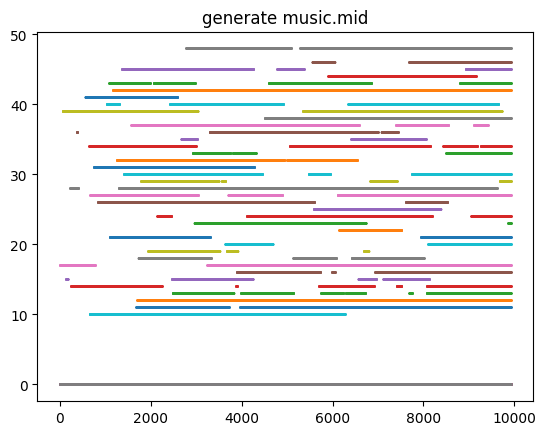

In [147]:
mmid = mido.MidiFile('output_test.mid')
result_array = mid2arry(mmid)

plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("generate music.mid")
plt.show()